In [4]:
from astropy.coordinates import SkyCoord, Galactocentric, Galactic
import astropy.units as u
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
import emcee
import corner

mainSeqStars = fits.open("fits_table/new_full_data.fits") #,memmap=True)
MSSdata = mainSeqStars[1].data
newMSSdata = MSSdata.newbyteorder().byteswap()  
df = pd.DataFrame(newMSSdata)
MainSeqQuery = df.query('MainSeqStar == True')

df = df.query("bp_rp-e_bp_min_rp_val < 0.8")
data = df.query("b>-20 & b<20")

#print(mainSeqStars[1].columns)

In [9]:
l = np.array(data['l'])
b = np.array(data['b'])
ra = np.array(data['ra'])#*u.deg)
dec = np.array(data['dec'])#*u.deg)
pm_ra_cosdec = np.array(data['pmra'])#*u.mas/u.yr)
pm_dec = np.array(data['pmdec'])#*u.mas/u.yr)
radial_velocity = np.array(data['radial_velocity'])#*u.km/u.s)
parallax = np.array(data['parallax'])

# define Skycoord 
skycoords = SkyCoord(ra =ra*u.deg, dec = dec*u.deg,\
                     pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, \
                     frame='icrs')

galcen = skycoords.transform_to(Galactic) #convert to Galactic coord
# mu_b = galcen.pm_b 
# mu_l = galcen.pm_l_cosb 

mu_b = galcen.pm_b * 4.74047 / u.mas * u.yr #* u.km/ u.s / u.kpc#convert from units of from mas yr-1 to units of km s-1 kpc-1 
mu_l = galcen.pm_l_cosb * 4.74047 / u.mas * u.yr#* u.km/ u.s / u.kpc#convert from units of from mas yr-1 to units of km s-1 kpc-1

u0 = 9.98#*u.km/u.s #km*s-1
v0 = 20.30#*u.km/u.s #km*s-1
w0 = 7.51#*u.km/u.s

mu_l_corrected = 1/np.cos(np.radians(b))*(mu_l-parallax*(u0*np.sin(np.radians(l))-v0*np.cos(np.radians(l))))

In [14]:
pmra = data['pmra']
pmdec = data['pmdec']
pmra_error = data['pmra_error']
pmdec_error = data['pmdec_error']

raG = np.radians(192.85948)
decG = np.radians(27.12825)
lNGP = np.radians(122.93192)

C1 = np.sin(decG)*np.cos(np.radians(dec))-np.cos(decG)*np.sin(np.radians(dec))*np.cos(np.radians(ra)-raG)
C2 = np.cos(decG)*np.sin(np.radians(ra)-raG)
cosb = 1/np.sqrt(C1**2+C2**2)
pm_l = 1/cosb*(C1*pmra+C2*pmdec)
pm_l_error = 1/cosb*(C1*pmra_error+C2*pmdec_error)
pm_l_error = pm_l_error*4.74047#/ u.mas * u.yr 
# convert to km s-1 kpc-1, and make it unitless
# print(pm_l_error[:10])

In [11]:
q_df_data = {'l':data['l'],
            'mu_l': mu_l_corrected,
            'pm_l_error': pm_l_error}
q_df = pd.DataFrame(q_df_data,columns=['l','mu_l','pm_l_error'])

In [15]:
# sort mu_l and error into l intevral of 5 degree
l_bin = np.arange(0,361,1)
mu_l_binned = [[] for _ in range(360)]
error_binned = [[] for _ in range(360)]
for j in np.arange(0,360,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    mu_l_binned[j] = q_df.query(qstr)['mu_l']
    error_binned[j] = q_df.query(qstr)['pm_l_error']

In [203]:
xdata=np.arange(0,360,1)
ydata = list(map(lambda i: np.mean(i), mu_l_binned))
y_error = list (map(lambda i: np.mean(i), error_binned))
# y_std = list(map(lambda i: np.std(i), mu_l_binned))
# use std of each interval as yerr
# y_std = np.array(y_std)
y_error = np.array(y_error)
y_std = np.std(ydata)

In [156]:
y_error =  list(map(lambda i: np.sqrt(np.sum(i**2)), error_binned))
y_error = np.array(y_error)

In [200]:
# x = error_binned[1]
# print(x[:10])
# print(np.sum(x[:10]**2))
print(y_error[::5])

[ 0.7239787   0.75904498  0.64895279  0.61352694  0.63941193  0.58905738
  0.60673146  0.63324853  0.54264438  0.53017324  0.49485601  0.45835678
  0.45471389  0.46558829  0.49564925  0.47414805  0.53254874  0.54270989
  0.48491412  0.51656291  0.53064952  0.46440287  0.37704846  0.37893876
  0.40444182  0.29055978  0.28712302  0.16223609  0.15394744  0.11568109
  0.07308773  0.05114821  0.00482394 -0.05155425 -0.08098648 -0.09662853
 -0.12756576 -0.12753386 -0.16309103 -0.16818185 -0.17811469 -0.14266284
 -0.18464814 -0.1780394  -0.16255495 -0.19244317 -0.17581147 -0.16360946
 -0.16499259 -0.13899521 -0.11580202 -0.1215721  -0.09267499 -0.07678244
 -0.03275454  0.00542193  0.06420628  0.12792469  0.17884124  0.2982656
  0.31843527  0.3979371   0.47881416  0.54049291  0.60545202  0.57022619
  0.64704839  0.61181045  0.62146528  0.71705459  0.71785092  0.74147457]


In [201]:
def model(x, param):
    A,B,C = theta
    y = A*np.cos(np.radians(2*x))-C*np.sin(np.radians(2*x))+B
    return y

16.16410691764285 -12.601316142302165 -2.0160276375805632


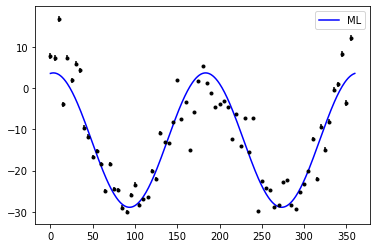

In [211]:
def ln_likelihood(theta,x,y,yerr):
    A,B,C = theta
    model = A*np.cos(np.radians(2*x))-C*np.sin(np.radians(2*x))+B
    LL = -0.5*np.sum((y-model)**2/(yerr**2+y_std**2))
    return LL  

np.random.seed(42)
nll = lambda*args: -ln_likelihood(*args)
inital =np.array([15, -14, -3])+0.1*np.random.randn(3)

soln = minimize(nll, inital, args=(xdata,ydata,y_error))
A_ml,B_ml,C_ml =  soln.x

print(A_ml,B_ml,C_ml)

plt.errorbar(xdata[::5],ydata[::5],yerr=y_error[::5], fmt='k.',capsize =0)
# plt.errorbar(xdata,ydata,yerr=y_error, fmt='k.',capsize =0)
x0 = np.linspace(0,360,361)
# plt.plot(x0, A_true*np.cos(np.radians(2*x0))-C_true*np.sin(np.radians(2*x0))+B_true, 'k', alpha=0.3, lw=3,label="truth")
plt.plot(x0, A_ml*np.cos(np.radians(2*x0))-C_ml*np.sin(np.radians(2*x0))+B_ml,"b-", lw=1.5,label='ML')
plt.legend()
plt.show()

In [205]:
y_std

12.403011321173258

In [206]:
def lnprior(theta):
    A,B,C= theta
    if 10<A<20 and -15<B<-5 and -10<C<5:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,x,y,yerr):
    lp = lnprior(theta)
    if np.isfinite(lp):
        return lp+ln_likelihood(theta,x,y,yerr)
    return -np.inf

In [207]:
pos0= soln.x+1e-4*np.random.randn(50,3)
nwalkers,ndim = 50,3

sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(xdata,ydata,y_error))
pos,prob,state = sampler.run_mcmc(pos0,100)

# burn0in first 100 iterations
sampler.reset()
runned = sampler.run_mcmc(pos,2000)

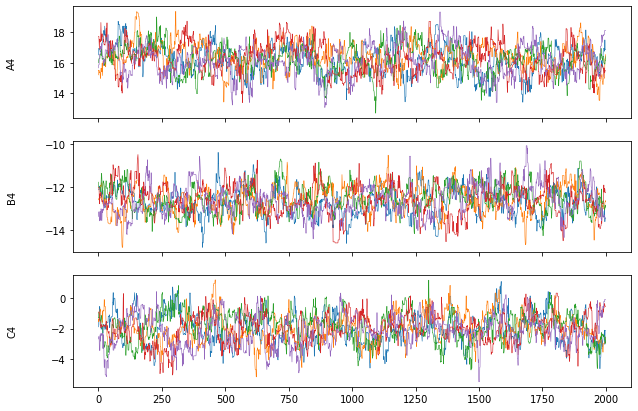

In [208]:
samples= sampler.get_chain()
labels = ['A','B','C']

fig,axes = plt.subplots(3,figsize=(10,7),sharex=True)
for i in range(ndim):
    ax = axes[i]
    for w in range(5):
        ax.plot(samples[:,w,i], alpha=1, lw=0.6)
#     ax.set_xlim(0,len(samples))
        ax.set_ylabel(labels[i]+str(w))
        ax.yaxis.set_label_coords(-0.1,0.5)
plt.savefig('plot/walkers.png')
plt.show()

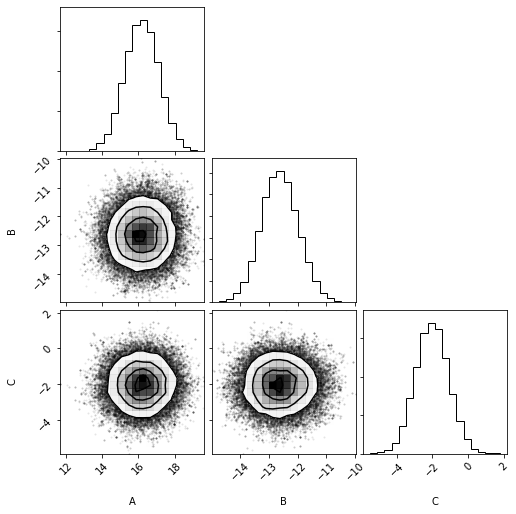

In [209]:
flat_samples= sampler.flatchain

fig = corner.corner(flat_samples, labels=labels)#,truths=[A_true,B_true,C_true])

plt.savefig('plot/MCMC_new.png')

50


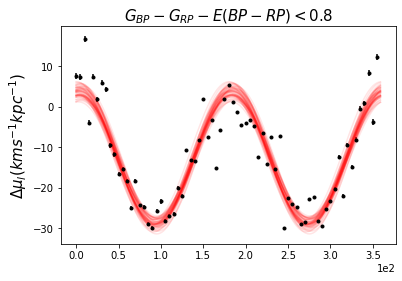

In [212]:
plt.errorbar(xdata[::5],ydata[::5],yerr=y_error[::5],fmt='k.')

g = 0 
for theta in flat_samples[np.random.randint(len(flat_samples),size=50)]:
    yPred = model(xdata,theta)
    plt.plot(xdata,yPred,'r',alpha=0.1)
    g += 1
print(g)

plt.ticklabel_format(style = 'sci',axis='x',scilimits=(0,0))
plt.ylabel('$\Delta \mu _l(kms^{-1}kpc^{-1})$',fontsize=15)
plt.title("$G_{BP}-G_{RP}-E(BP-RP)<0.8$",fontsize=15)
plt.savefig('plot/08MCMC_new.png')
plt.show()


In [101]:
print(np.shape(samples))

(2000, 50, 3)
